## Imports, Seed & Config

In [2]:
# CSE366 — Stage 3 (Transfer Learning): 4 Backbones on CitrusFruit


import os, json, random, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix


print("CUDA available?        ", torch.cuda.is_available())
print("CUDA device count:     ", torch.cuda.device_count())
print("Selected device str:   ", "cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Device 0 name:         ", torch.cuda.get_device_name(0))


print("CUDA available?", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
use_amp = (device.type == "cuda")

from pathlib import Path


DATA_ROOT = Path("/kaggle/input/a-dataset-of-citrus-fruit-images/A Dataset of Citrus Fruit Images/CitrusFruit/Augmentation")

train_dir = DATA_ROOT / "Train-A"
val_dir   = DATA_ROOT / "Val-A"
test_dir  = DATA_ROOT / "Test-A"

print("Train exists?", train_dir.exists())
print("Val exists?", val_dir.exists())
print("Test exists?", test_dir.exists())


IM_SIZE    = 160                             # was 224
BATCH_SIZE = 32
NUM_WORKERS= 2

# Training schedule
PHASE1_EPOCHS = 1   # head-only warmup       # was 3
PHASE2_EPOCHS = 2   # fine-tune              # was 7
EARLY_STOP_PATIENCE = 2                     # was 3

LR_HEAD   = 3e-3
LR_FT     = 1e-4
WEIGHT_DECAY = 1e-4

RESULTS_CSV = "transfer_learning_results.csv"

CUDA available?         True
CUDA device count:      1
Selected device str:    cuda
Device 0 name:          Tesla P100-PCIE-16GB
CUDA available? True
Device: Tesla P100-PCIE-16GB
Device: cuda
Train exists? True
Val exists? True
Test exists? True


# 1) Transforms, Datasets, DataLoaders

In [3]:
# ==========================================
# 1) Transforms, Datasets, Data Loaders
# ==========================================
train_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(DATA_ROOT/"Train-A", transform=train_tfms)
val_ds   = datasets.ImageFolder(DATA_ROOT/"Val-A",   transform=eval_tfms)
test_ds  = datasets.ImageFolder(DATA_ROOT/"Test-A",  transform=eval_tfms)

CLASSES = train_ds.classes
NUM_CLASSES = len(CLASSES)
print("Classes:", CLASSES)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)



Classes: ['murcott', 'ponkan', 'tangerine', 'tankan']


# 2) AMP, Eval Helpers, Metrics

In [4]:
# ============================================
# 2) AMP, Eval Helpers, Metric  (PyTorch-1.x)
# ============================================

from torch import amp

use_amp = (device.type == "cuda")
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_t, all_p = [], []
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)
        pred = logits.argmax(1)
        total_loss += loss.item() * y.size(0)
        correct    += (pred == y).sum().item()
        total      += y.size(0)
        all_t.extend(y.detach().cpu().tolist())
        all_p.extend(pred.detach().cpu().tolist())
    avg_loss = total_loss/total
    acc = correct/total
    report = classification_report(all_t, all_p, target_names=CLASSES, output_dict=True, zero_division=0)
    f1_macro = report["macro avg"]["f1-score"]
    return avg_loss, acc, f1_macro, np.array(all_t), np.array(all_p)


# 3) Model Factory (choose 4 different backbones)

In [5]:
# =================================================
# 3) Model Factory (choose 4 different backbones)
# =================================================

import torchvision.models as tvm

def make_model(backbone_name: str, num_classes: int):
    name = backbone_name.lower()
    if name == "resnet34":
        m = tvm.resnet34(weights=tvm.ResNet34_Weights.DEFAULT)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
        classifier_params = list(m.fc.parameters())
    elif name == "densenet121":
        m = tvm.densenet121(weights=tvm.DenseNet121_Weights.DEFAULT)
        in_feats = m.classifier.in_features
        m.classifier = nn.Linear(in_feats, num_classes)
        classifier_params = list(m.classifier.parameters())
    elif name == "efficientnet_b0":
        m = tvm.efficientnet_b0(weights=tvm.EfficientNet_B0_Weights.DEFAULT)
        in_feats = m.classifier[1].in_features
        m.classifier[1] = nn.Linear(in_feats, num_classes)
        classifier_params = list(m.classifier[1].parameters())
    elif name == "convnext_tiny":
        m = tvm.convnext_tiny(weights=tvm.ConvNeXt_Tiny_Weights.DEFAULT)
        in_feats = m.classifier[2].in_features
        m.classifier[2] = nn.Linear(in_feats, num_classes)
        classifier_params = list(m.classifier[2].parameters())
    else:
        raise ValueError(f"Unknown backbone: {backbone_name}")

    return m.to(device), classifier_params

BACKBONES = ["resnet34", "densenet121", "efficientnet_b0", "convnext_tiny"]
print("Planned backbones:", BACKBONES)



Planned backbones: ['resnet34', 'densenet121', 'efficientnet_b0', 'convnext_tiny']


# 4) Train Utilities (freeze/unfreeze, one epoch runner)

In [6]:
# ========================================================
# 4) Train Utilities (freeze/unfreeze, one epoch runner)
# ========================================================

def set_trainable(module, flag=True):
    for p in module.parameters():
        p.requires_grad = flag

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * y.size(0)
        correct    += (logits.argmax(1) == y).sum().item()
        total      += y.size(0)
    return total_loss/total, correct/total


# 5) Run Training for Each Backbone

In [7]:
# ==========================================
# 5) Run Training for Each Backbone
# ==========================================

results = []

for name in BACKBONES:
    print(f"\n===== Backbone: {name} =====")
    model, cls_params = make_model(name, NUM_CLASSES)

    # -------- Phase 1: freeze backbone, train head only --------
    set_trainable(model, False)
    for p in cls_params:  # re-enable classifier head
        p.requires_grad = True

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                  lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1)
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    best_f1 = -1.0
    epochs_no_improve = 0
    best_path = f"tl_{name}_best.pt"

    for epoch in range(1, PHASE1_EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)
        scheduler.step(val_f1)
        print(f"[{name} | Phase1 | Ep {epoch}/{PHASE1_EPOCHS}] train_loss {tr_loss:.4f} acc {tr_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")

        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1; epochs_no_improve = 0
            torch.save({"model_state": model.state_dict(), "arch": name, "val_f1": best_f1}, best_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print("  Early stop (Phase1)."); break

    # -------- Phase 2: unfreeze & fine-tune --------
    set_trainable(model, True)  # unfreeze all (or selectively if you want)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_FT, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=1)
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    epochs_no_improve = 0

    for epoch in range(1, PHASE2_EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)
        scheduler.step(val_f1)
        print(f"[{name} | Phase2 | Ep {epoch}/{PHASE2_EPOCHS}] train_loss {tr_loss:.4f} acc {tr_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f} f1 {val_f1:.4f}")

        if val_f1 > best_f1 + 1e-4:
            best_f1 = val_f1; epochs_no_improve = 0
            torch.save({"model_state": model.state_dict(), "arch": name, "val_f1": best_f1}, best_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print("  Early stop (Phase2)."); break

    # -------- Test best checkpoint --------
    ckpt = torch.load(best_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    model.to(device)
    test_loss, test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader)

    report = classification_report(y_true, y_pred, target_names=CLASSES, zero_division=0, output_dict=True)
    row = {
        "backbone": name,
        "val_best_f1": best_f1,
        "test_loss": test_loss,
        "test_acc":  test_acc,
        "test_macro_f1": test_f1,
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "weights": f"tl_{name}_best.pt"
    }
    results.append(row)
    print("→", row)

df = pd.DataFrame(results).sort_values("test_macro_f1", ascending=False)
display(df)
df.to_csv(RESULTS_CSV, index=False)
print("Saved:", RESULTS_CSV)



===== Backbone: resnet34 =====


/tmp/ipykernel_152/2234858659.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[resnet34 | Phase1 | Ep 1/1] train_loss 0.5193 acc 0.8076 | val_loss 0.3511 acc 0.8824 f1 0.8811


/tmp/ipykernel_152/2234858659.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[resnet34 | Phase2 | Ep 1/2] train_loss 0.1370 acc 0.9481 | val_loss 0.1829 acc 0.9497 f1 0.9502


/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[resnet34 | Phase2 | Ep 2/2] train_loss 0.0413 acc 0.9860 | val_loss 0.1466 acc 0.9576 f1 0.9582


/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


→ {'backbone': 'resnet34', 'val_best_f1': 0.9582480241102557, 'test_loss': 0.1268279984411176, 'test_acc': 0.9637681159420289, 'test_macro_f1': 0.9645180906050472, 'precision_macro': 0.9656432748538012, 'recall_macro': 0.964745670995671, 'weights': 'tl_resnet34_best.pt'}

===== Backbone: densenet121 =====


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 59.6MB/s]
/tmp/ipykernel_152/2234858659.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[densenet121 | Phase1 | Ep 1/1] train_loss 0.3911 acc 0.8620 | val_loss 0.2627 acc 0.9194 f1 0.9199


/tmp/ipykernel_152/2234858659.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[densenet121 | Phase2 | Ep 1/2] train_loss 0.0892 acc 0.9695 | val_loss 0.0910 acc 0.9685 f1 0.9684


/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[densenet121 | Phase2 | Ep 2/2] train_loss 0.0274 acc 0.9902 | val_loss 0.1083 acc 0.9709 f1 0.9706


/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


→ {'backbone': 'densenet121', 'val_best_f1': 0.9705828396371238, 'test_loss': 0.13218254455611148, 'test_acc': 0.9710144927536232, 'test_macro_f1': 0.9703775046372736, 'precision_macro': 0.9727564102564102, 'recall_macro': 0.9696428571428571, 'weights': 'tl_densenet121_best.pt'}

===== Backbone: efficientnet_b0 =====


100%|██████████| 20.5M/20.5M [00:00<00:00, 36.7MB/s]
/tmp/ipykernel_152/2234858659.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[efficientnet_b0 | Phase1 | Ep 1/1] train_loss 0.4328 acc 0.8482 | val_loss 0.2377 acc 0.9176 f1 0.9173


/tmp/ipykernel_152/2234858659.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[efficientnet_b0 | Phase2 | Ep 1/2] train_loss 0.1631 acc 0.9405 | val_loss 0.0969 acc 0.9588 f1 0.9595


/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[efficientnet_b0 | Phase2 | Ep 2/2] train_loss 0.0655 acc 0.9771 | val_loss 0.1012 acc 0.9630 f1 0.9640


/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


→ {'backbone': 'efficientnet_b0', 'val_best_f1': 0.9639769157409197, 'test_loss': 0.09864503231606711, 'test_acc': 0.9710144927536232, 'test_macro_f1': 0.9703837278346064, 'precision_macro': 0.969955289808231, 'recall_macro': 0.9709956709956711, 'weights': 'tl_efficientnet_b0_best.pt'}

===== Backbone: convnext_tiny =====


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:02<00:00, 39.3MB/s] 
/tmp/ipykernel_152/2234858659.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[convnext_tiny | Phase1 | Ep 1/1] train_loss 0.2852 acc 0.9023 | val_loss 0.1868 acc 0.9503 f1 0.9511


/tmp/ipykernel_152/2234858659.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[convnext_tiny | Phase2 | Ep 1/2] train_loss 0.0662 acc 0.9762 | val_loss 0.0859 acc 0.9709 f1 0.9712


/tmp/ipykernel_152/2754635507.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[convnext_tiny | Phase2 | Ep 2/2] train_loss 0.0108 acc 0.9965 | val_loss 0.0791 acc 0.9758 f1 0.9757


/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


→ {'backbone': 'convnext_tiny', 'val_best_f1': 0.9757359371747767, 'test_loss': 0.06640297260836948, 'test_acc': 0.9710144927536232, 'test_macro_f1': 0.9703775046372736, 'precision_macro': 0.9727564102564102, 'recall_macro': 0.9696428571428571, 'weights': 'tl_convnext_tiny_best.pt'}


,backbone,val_best_f1,test_loss,test_acc,test_macro_f1,precision_macro,recall_macro,weights
2,efficientnet_b0,0.963977,0.098645,0.971014,0.970384,0.969955,0.970996,tl_efficientnet_b0_best.pt
1,densenet121,0.970583,0.132183,0.971014,0.970378,0.972756,0.969643,tl_densenet121_best.pt
3,convnext_tiny,0.975736,0.066403,0.971014,0.970378,0.972756,0.969643,tl_convnext_tiny_best.pt
0,resnet34,0.958248,0.126828,0.963768,0.964518,0.965643,0.964746,tl_resnet34_best.pt


Saved: transfer_learning_results.csv


# 6) Confusion Matrix for the Top Model

Best backbone by test_macro_f1: efficientnet_b0


/tmp/ipykernel_152/2019446316.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


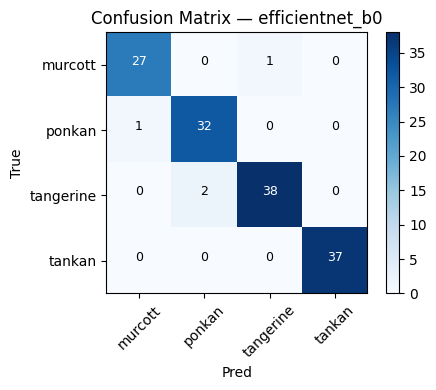

In [8]:
# ==========================================
# 6) Confusion Matrix for the Top Model
# ==========================================

# Plot confusion matrix for the best model
best_name = df.iloc[0]["backbone"]
print("Best backbone by test_macro_f1:", best_name)
ckpt = torch.load(f"tl_{best_name}_best.pt", map_location="cpu")

# Recreate the model skeleton, load weights
m, _ = make_model(best_name, NUM_CLASSES)
m.load_state_dict(ckpt["model_state"]); m.to(device)

_, _, _, y_true, y_pred = evaluate(m, test_loader)
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix — {best_name}"); plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, CLASSES, rotation=45); plt.yticks(ticks, CLASSES)
th = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center",
                 color="white" if cm[i,j] > th else "black", fontsize=9)
plt.ylabel("True"); plt.xlabel("Pred"); plt.tight_layout(); plt.show()




# 7) Load & evaluate Stage-B custom CNN (CitrusNet) for side-by-side comparison

In [10]:
# ===============================================================================
# 7) Load & evaluate Stage-B custom CNN (CitrusNet) for side-by-side comparison
# ===============================================================================

import torch.nn as nn
import torch.nn.functional as F
from torch import amp

# Re-declare the same custom model you used in Stage B
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=stride, padding=1, groups=in_ch, bias=False)
        self.dw_bn = nn.BatchNorm2d(in_ch)
        self.pw = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        self.pw_bn = nn.BatchNorm2d(out_ch)
        self.drop = nn.Dropout(p_drop) if p_drop>0 else nn.Identity()
    def forward(self, x):
        x = F.relu(self.dw_bn(self.dw(x)), inplace=True)
        x = F.relu(self.pw_bn(self.pw(x)), inplace=True)
        x = self.drop(x); return x

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, p_drop=0.0):
        super().__init__()
        self.conv = DepthwiseSeparableConv(in_ch, out_ch, stride=stride, p_drop=p_drop)
        self.proj = None
        if stride != 1 or in_ch != out_ch:
            self.proj = nn.Sequential(nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                                      nn.BatchNorm2d(out_ch))
    def forward(self, x):
        out = self.conv(x)
        res = x if self.proj is None else self.proj(x)
        return F.relu(out + res, inplace=True)

class CitrusNet(nn.Module):
    def __init__(self, num_classes=4, width=(32,64,128,256), p_drop=0.10):
        super().__init__()
        w1, w2, w3, w4 = width
        self.stem = nn.Sequential(nn.Conv2d(3, w1, 3, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(w1), nn.ReLU(inplace=True))
        self.stage1 = ResidualBlock(w1,  w2, stride=1, p_drop=p_drop)
        self.stage2 = ResidualBlock(w2,  w2, stride=1, p_drop=p_drop)
        self.stage3 = ResidualBlock(w2,  w3, stride=2, p_drop=p_drop)
        self.stage4 = ResidualBlock(w3,  w3, stride=1, p_drop=p_drop)
        self.stage5 = ResidualBlock(w3,  w4, stride=2, p_drop=p_drop)
        self.stage6 = ResidualBlock(w4,  w4, stride=1, p_drop=p_drop)
        self.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(0.30), nn.Linear(w4, num_classes))
        # init
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if isinstance(m, nn.BatchNorm2d): nn.init.constant_(m.weight, 1.0); nn.init.constant_(m.bias, 0.0)
    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x); x = self.stage2(x)
        x = self.stage3(x); x = self.stage4(x)
        x = self.stage5(x); x = self.stage6(x)
        x = self.head(x)
        return x

# Loaded the checkpoint from Stage B
custom_path = "/kaggle/input/citrusnet-custom-cnn/pytorch/1/1/custom_cnn_best.pt"
ckpt_custom = torch.load(custom_path, map_location="cpu")

custom_model = CitrusNet(num_classes=NUM_CLASSES).to(device)
custom_model.load_state_dict(ckpt_custom["model_state"])
custom_model.eval()

# Evaluate on the same test_loader used by TL
criterion = nn.CrossEntropyLoss()
use_amp = (device.type == "cuda")
@torch.no_grad()
def eval_only(model, loader):
    model.eval()
    all_t, all_p = [], []
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with amp.autocast(device_type="cuda", enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)
        pred = logits.argmax(1)
        total_loss += loss.item() * y.size(0)
        correct += (pred == y).sum().item()
        total += y.size(0)
        all_t.extend(y.detach().cpu().tolist())
        all_p.extend(pred.detach().cpu().tolist())
    from sklearn.metrics import classification_report
    rep = classification_report(all_t, all_p, target_names=CLASSES, output_dict=True, zero_division=0)
    return total_loss/total, correct/total, rep["macro avg"]["f1-score"]

cust_loss, cust_acc, cust_f1 = eval_only(custom_model, test_loader)
print(f"Custom CNN (Stage-B) on TEST | loss {cust_loss:.4f} | acc {cust_acc:.4f} | macro-F1 {cust_f1:.4f}")


Custom CNN (Stage-B) on TEST | loss 0.1310 | acc 0.9638 | macro-F1 0.9628


# 8) Add custom CNN row to the TL results table and display/save

In [ ]:
# ==================================================================
# 8) Add custom CNN row to the TL results table and display/save  (By Deb)
# ==================================================================

custom_row = {
    "backbone": "custom_cnn",
    "val_best_f1": ckpt_custom.get("val_f1", None),
    "test_loss": cust_loss,
    "test_acc":  cust_acc,
    "test_macro_f1": cust_f1,
    "precision_macro": None,   # you can compute again if needed
    "recall_macro": None,
    "weights": "custom_cnn_best.pt"
}

df_combined = pd.concat([df, pd.DataFrame([custom_row])], ignore_index=True).sort_values("test_macro_f1", ascending=False)
display(df_combined)
df_combined.to_csv("combined_results_with_custom.csv", index=False)
print("Saved: combined_results_with_custom.csv")


/tmp/ipykernel_152/2563812395.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df, pd.DataFrame([custom_row])], ignore_index=True).sort_values("test_macro_f1", ascending=False)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-

,backbone,val_best_f1,test_loss,test_acc,test_macro_f1,precision_macro,recall_macro,weights
0,efficientnet_b0,0.963977,0.098645,0.971014,0.970384,0.969955,0.970996,tl_efficientnet_b0_best.pt
1,densenet121,0.970583,0.132183,0.971014,0.970378,0.972756,0.969643,tl_densenet121_best.pt
2,convnext_tiny,0.975736,0.066403,0.971014,0.970378,0.972756,0.969643,tl_convnext_tiny_best.pt
3,resnet34,0.958248,0.126828,0.963768,0.964518,0.965643,0.964746,tl_resnet34_best.pt
4,custom_cnn,0.922605,0.130963,0.963768,0.962815,NaN,NaN,custom_cnn_best.pt


Saved: combined_results_with_custom.csv
